In [1]:
import random
import gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
EPOCHS = 1000
THRESHOLD = 10
MONITOR = True

In [3]:
class DQN():
    def __init__(self, env_string,batch_size=64, IM_SIZE = 84, m = 4):
        self.memory = deque(maxlen=5000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.IM_SIZE = IM_SIZE
        self.m = m       
        
        alpha=0.01
        alpha_decay=0.01
        
        if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
        
        self.model = Sequential()
        self.model.add( Conv2D(32, 8, (4,4), activation='relu',padding='valid', input_shape=(IM_SIZE, IM_SIZE, m)))
        #self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 4, (2,2), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 3, (1,1), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='elu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))
        self.model_target = tf.keras.models.clone_model(self.model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def preprocess_state(self, img):
        img_temp = img[31:195]
        img_temp = tf.image.rgb_to_grayscale(img_temp)
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img_temp = tf.cast(img_temp, tf.float32)
        
        return img_temp[:,:,0]

    def combine_images(self, img1, img2):
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:, :],np.expand_dims(img2,0), axis=2)
            return tf.expand_dims(im, 0)
        
        else:
            im = np.stack([img1]*self.m, axis = 2)
            return tf.expand_dims(im, 0)
        #return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       
    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        
        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            state = self.combine_images(state, state)
            done = False
            i = 0
            
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                next_state = self.combine_images(next_state, state)
                #print(next_state.shape)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            
            if mean_score >= THRESHOLD:
                print('Solved after {} trials ✔'.format(e))
                
                return avg_scores
            
            if e % 10 == 0:
                print('[Episode {}] - Average Score: {}.'.format(e, mean_score))
                self.model_target.set_weights(self.model.get_weights())

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        
        return avg_scores

In [4]:
env_string = 'BreakoutDeterministic-v4'
agent = DQN(env_string)

In [5]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [6]:
agent.model_target.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [7]:
scores = agent.train()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[Episode 0] - Average Score: 3.0.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorF

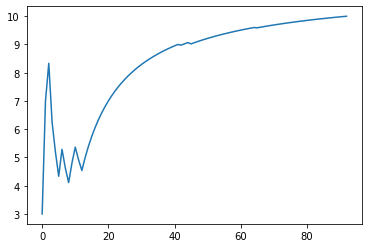

In [8]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.show()

In [9]:
agent.env.close()